# G27
Dave Brunner

In [1]:
import glob
import os
import string

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### Load Data

The names can be found in text files in a src directory, one file per language.

In the following you can find some utilities to load the data into pandas data frames. 

We will restrict to some common European languages. 

With the given selection, we will identify all the occurring characters and initialize an alphabet.<br>
For this alphabet, we will use a one-hot-encoding to map them into a vector space representation. 

Foresee a suitable character for the end of the word, e.g. 'END'.

In [2]:
srcdir = 'data/names'
languages = ["English", "French", "Italian", "German", "Spanish"]

In [3]:
# inspect the data directory
def findFiles(path):
    return glob.glob(path)

In [4]:
print('\n'.join(findFiles(os.path.join(srcdir, '*.txt'))))

data/names/Czech.txt
data/names/German.txt
data/names/Arabic.txt
data/names/Japanese.txt
data/names/Chinese.txt
data/names/Vietnamese.txt
data/names/Russian.txt
data/names/French.txt
data/names/Irish.txt
data/names/English.txt
data/names/Spanish.txt
data/names/Greek.txt
data/names/Italian.txt
data/names/Portuguese.txt
data/names/Scottish.txt
data/names/Dutch.txt
data/names/Korean.txt
data/names/Polish.txt


In [5]:
# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return lines


def load_data(srcdir, categories=None):
    names_list = []
    for filename in findFiles(os.path.join(srcdir, '*.txt')):
        category = os.path.splitext(os.path.basename(filename))[0]
        if not categories or category in categories:
            names = readLines(filename)
            names_list.extend([(name, category) for name in names])
    df = pd.DataFrame(names_list)
    df.columns = ["name", "lang"]
    return df

In [6]:
names = load_data(srcdir, categories=languages)
names.head()

,name,lang
0,Abbing,German
1,Abel,German
2,Abeln,German
3,Abt,German
4,Achilles,German


In [7]:
maxlen = np.max([len(name) for name in names.name])
print("Maximum name length: ", maxlen)

Maximum name length:  18


In [8]:
print(f'There are {len(names)} names in the dataset')

There are 5676 names in the dataset


In [9]:
alphabet = sorted(list(set(''.join([name for name in names.name]))))
alphabet.append('END')
len_alphabet = len(alphabet)
char_index = dict((c, i) for i, c in enumerate(alphabet))
print("Size of alphabet: ", len_alphabet)
print(alphabet)

Size of alphabet:  74
[' ', "'", 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'Á', 'É', 'ß', 'à', 'á', 'ä', 'ç', 'è', 'é', 'ê', 'ì', 'í', 'ñ', 'ò', 'ó', 'ö', 'ù', 'ú', 'ü', 'END']


In [10]:
names.groupby('lang')['name'].count() / len(names)

lang
English    0.646230
French     0.048802
German     0.127555
Italian    0.124912
Spanish    0.052502
Name: name, dtype: float64

### Vector Representations

Now construct the vector representation by using one-hot-vectors. 

In [11]:
language_to_index = {country: index for index, country in enumerate(names.lang.unique())}
index_to_language = {index: country for index, country in enumerate(names.lang.unique())}


def onehot(i, length):
    v = np.zeros(length);
    v[i] = 1
    return v


def name_representation(name, maxlen):
    name_trunc = str(name)[0:maxlen]
    size = len(char_index)
    vector = [onehot(char_index[j], size) for j in str(name)]
    # fill the rest with 
    for k in range(0, maxlen - len(str(name))):
        vector.append(onehot(char_index['END'], size))
    return vector


def lang_representation(language, language_to_index):
    y = np.zeros(len(language_to_index))
    y[language_to_index[language]] = 1
    return y


def lang_from_output(score):
    return index_to_language[np.argmax(score)]


def predict(name, model):
    score = model.predict(np.array([name_representation(name, maxlen)]))[0]
    return lang_from_output(score)

### Prepare train/test

Split the data into train/test

Shuffle the data

Transform the names data into a suitable vector respresentation:
* names into numpy arrays of shape (*,maxlen,len_alphabet)
* language into numpy array of shape (*,len(languages))



In [12]:
test_split = 0.2

# Shuffle and split names data
names = names.sample(frac=1).reset_index(drop=True)
print(names.head())

train = names[int(len(names) * test_split):]
test = names[:int(len(names) * test_split)]

     name     lang
0   Mundy  English
1  Macrae  English
2    Nedd  English
3  Temple  English
4  Grange  English


In [13]:
print(f'Train names total: {train.shape[0]}')
print(f'English names: {train[train.lang == 'English'].shape[0]}')
print(f'French  names: {train[train.lang == "French"].shape[0]}')
print(f'Italian names: {train[train.lang == "Italian"].shape[0]}')
print(f'German  names: {train[train.lang == "German"].shape[0]}')
print(f'Spanish names: {train[train.lang == "Spanish"].shape[0]}')

Train names total: 4541
English names: 2942
French  names: 217
Italian names: 564
German  names: 580
Spanish names: 238


In [14]:
print(f'Test names total: {test.shape[0]}')
print(f'English names: {test[test.lang == "English"].shape[0]}')
print(f'French  names: {test[test.lang == "French"].shape[0]}')
print(f'Italian names: {test[test.lang == "Italian"].shape[0]}')
print(f'German  names: {test[test.lang == "German"].shape[0]}')
print(f'Spanish names: {test[test.lang == "Spanish"].shape[0]}')

Test names total: 1135
English names: 726
French  names: 60
Italian names: 145
German  names: 144
Spanish names: 60


In [15]:
# Map train and test data into vector space (one-hot-vectors)

X_train = np.array([name_representation(name, maxlen) for name in train.name])
Y_train = np.array([lang_representation(lang, language_to_index) for lang in train.lang])

X_test = np.array([name_representation(name, maxlen) for name in test.name])
Y_test = np.array([lang_representation(lang, language_to_index) for lang in test.lang])

langs = [index_to_language[i] for i in range(len(language_to_index))]
print(langs)

['German', 'French', 'English', 'Spanish', 'Italian']


In [16]:
print(Y_test.shape)
# count all the languages
print(Y_test.sum(axis=0))


(1135, 5)
[144.  60. 726.  60. 145.]


In [17]:
print(X_train.shape)
print(X_test.shape)
print(X_train[0].shape)

(4541, 18, 74)
(1135, 18, 74)
(18, 74)


### Define and Train Model: Single Layer with SimpleRNN

Create an RNN consisting of a single layer with a SimpleRNN and a softmax.

Then train the model. Play with different number of hidden units in the layer to obtain a good accuracy.

In [18]:
from keras.src.layers import SimpleRNN, Dense, InputLayer
from keras import Sequential


def build_model(n_hidden):
    model = Sequential()
    model.add(InputLayer(shape=(maxlen, len_alphabet)))
    model.add(SimpleRNN(n_hidden))
    model.add(Dense(len(languages), activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


model = build_model(n_hidden=128)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 128)            │        25,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,629 (104.02 KB)

 Trainable params: 26,629 (104.02 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
def plot_history(history):
    print(f"Train accuracy: {history.history['accuracy'][-1]:.3f}")
    print(f"Test  accuracy: {history.history['val_accuracy'][-1]:.3f}")
    plt.figure(figsize=(13, 3))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.show()

def plot_confusion_matrix(model):
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=-1)
    y_true = np.argmax(Y_test, axis=-1)
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=langs)
    disp.plot(colorbar=True, cmap='Blues')

In [20]:
model = build_model(n_hidden=32)
history = model.fit(X_train, Y_train, epochs=20, batch_size=128, validation_data=(X_test, Y_test), verbose=0)

Train accuracy: 0.777
Test  accuracy: 0.742


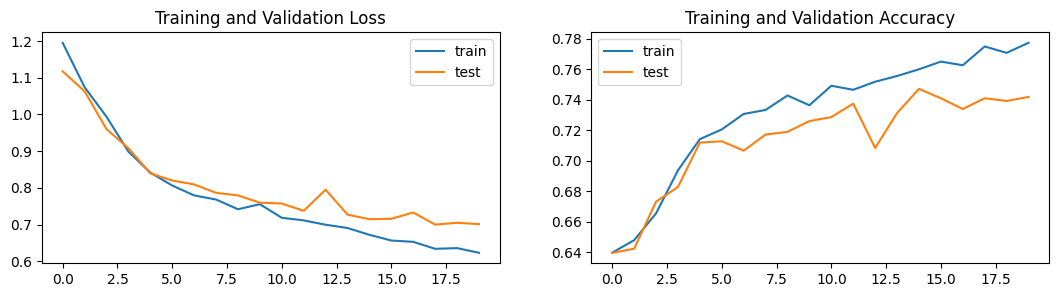

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


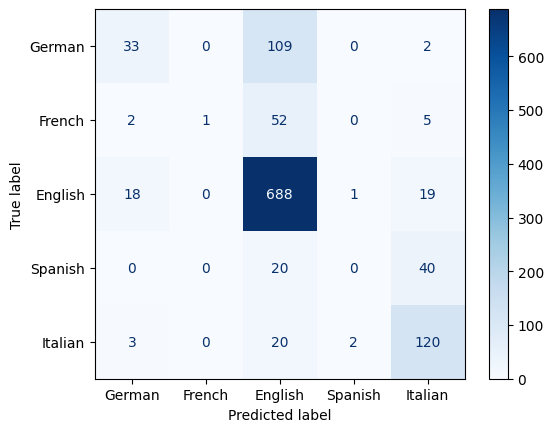

In [21]:
plot_history(history)
plot_confusion_matrix(model)

In [22]:
model = build_model(n_hidden=64)
history = model.fit(X_train, Y_train, epochs=20, batch_size=128, validation_data=(X_test, Y_test), verbose=0)

Train accuracy: 0.839
Test  accuracy: 0.762


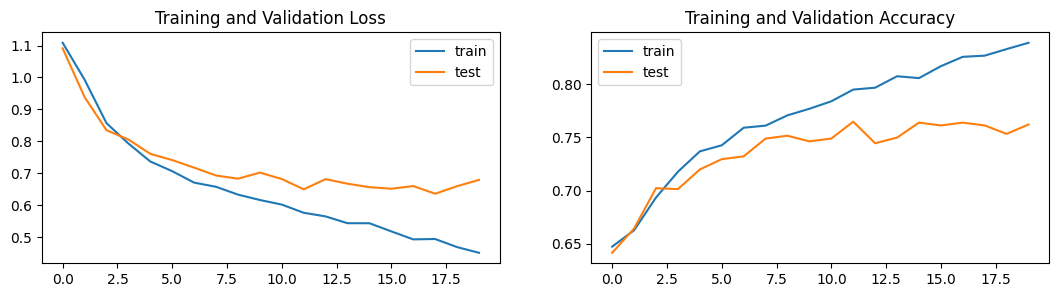

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


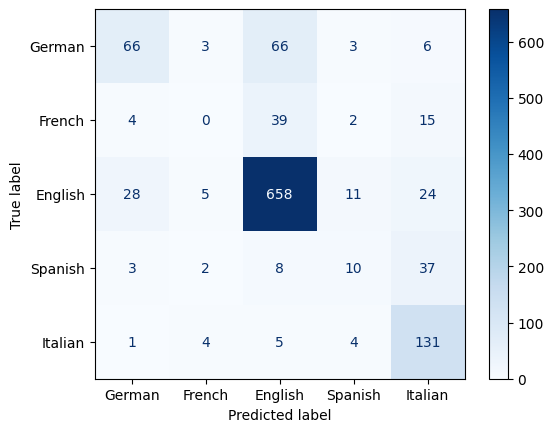

In [23]:
plot_history(history)
plot_confusion_matrix(model)

In [24]:
model = build_model(n_hidden=85)
history = model.fit(X_train, Y_train, epochs=20, batch_size=128, validation_data=(X_test, Y_test), verbose=0)

Train accuracy: 0.849
Test  accuracy: 0.763


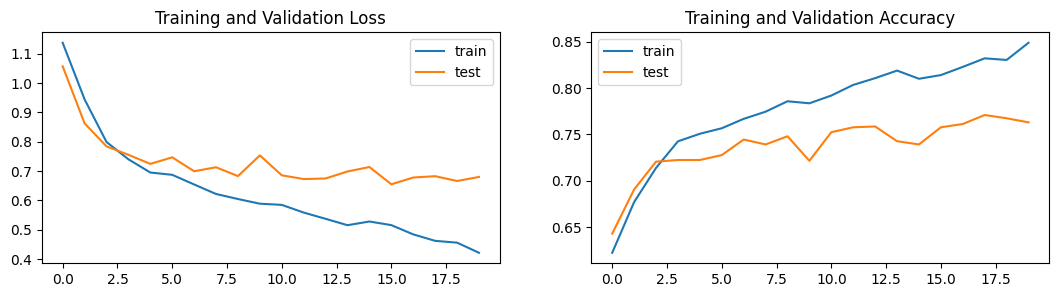

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


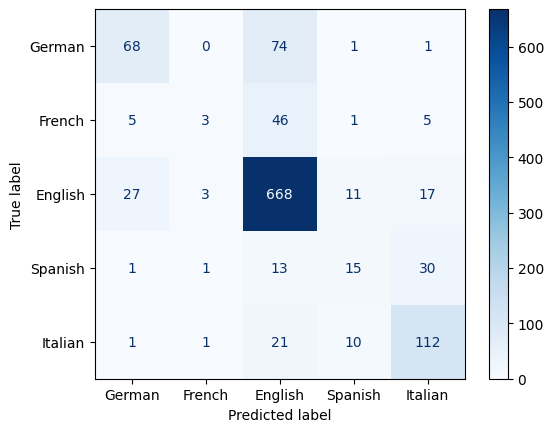

In [25]:
plot_history(history)
plot_confusion_matrix(model)

In [26]:
model = build_model(n_hidden=100)
history = model.fit(X_train, Y_train, epochs=20, batch_size=128, validation_data=(X_test, Y_test), verbose=0)

Train accuracy: 0.862
Test  accuracy: 0.767


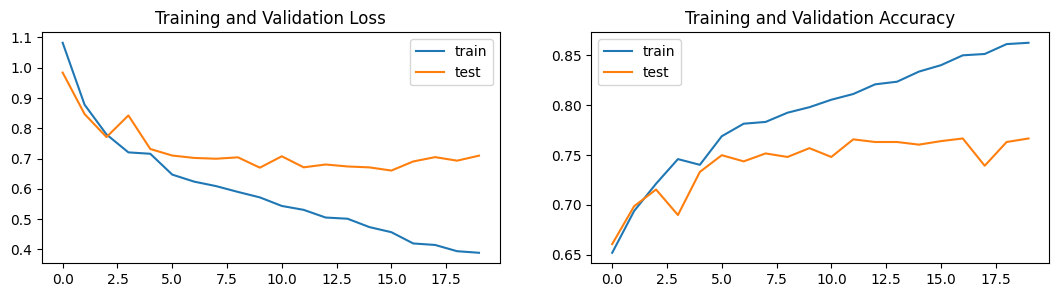

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


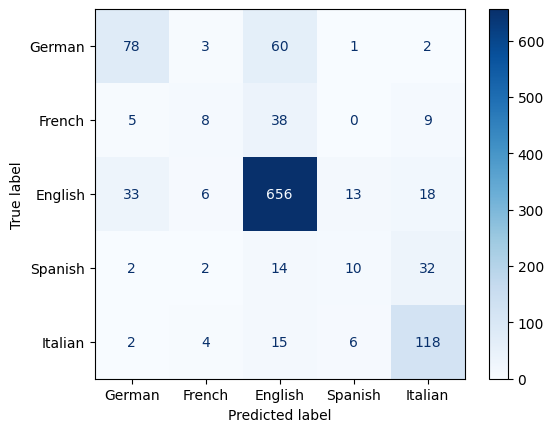

In [27]:
plot_history(history)
plot_confusion_matrix(model)

In [28]:
model = build_model(n_hidden=128)
history = model.fit(X_train, Y_train, epochs=20, batch_size=128, validation_data=(X_test, Y_test), verbose=0)

Train accuracy: 0.888
Test  accuracy: 0.753


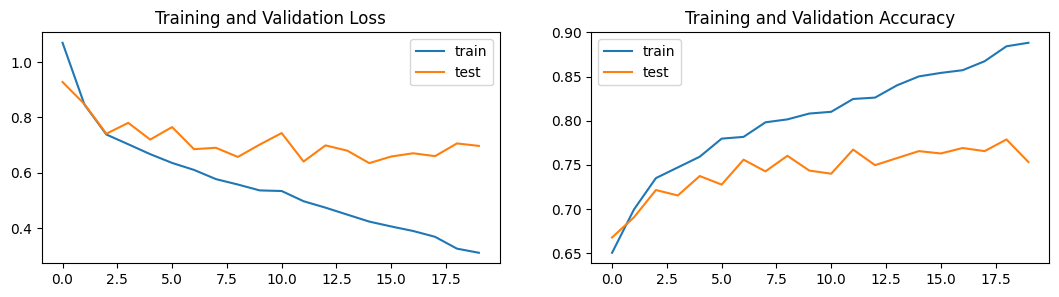

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


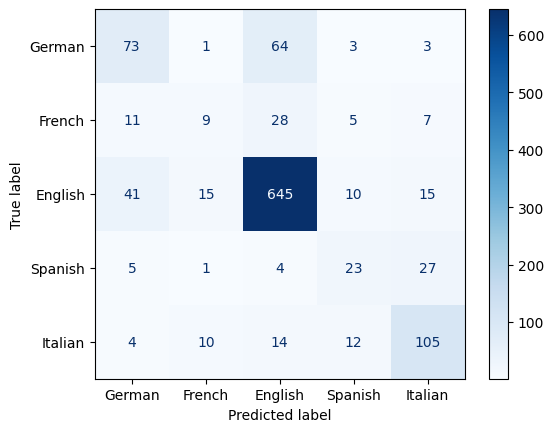

In [29]:
plot_history(history)
plot_confusion_matrix(model)

#### Findings

The performance in general is quite good on the training set and the test set. The model is able to predict the language of the name with an accuracy of around 75% on the test set.
The difference in different number of hidden units, number of epochs, batch size do not have a huge influence on the performance of the model.


### Implement Model with several SimpleRNN Layers

In [30]:
def build_model_multi(n_hidden):
    model = Sequential()
    model.add(InputLayer(shape=(maxlen, len_alphabet)))
    model.add(SimpleRNN(n_hidden, return_sequences=True))
    model.add(SimpleRNN(n_hidden, return_sequences=True))
    model.add(SimpleRNN(n_hidden, return_sequences=True))
    # model.add(SimpleRNN(n_hidden, return_sequences=True))
    model.add(SimpleRNN(n_hidden))
    model.add(Dense(len(languages), activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


model = build_model_multi(n_hidden=128)
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_6 (SimpleRNN)        │ (None, 18, 128)        │        25,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_7 (SimpleRNN)        │ (None, 18, 128)        │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_8 (SimpleRNN)        │ (None, 18, 128)        │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_9 (SimpleRNN)        │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 125,317 (489.52 KB)

 Trainable params: 125,317 (489.52 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
model = build_model_multi(n_hidden=32)
history = model.fit(X_train, Y_train, epochs=20, batch_size=128, validation_data=(X_test, Y_test), verbose=0)

Train accuracy: 0.862
Test  accuracy: 0.763


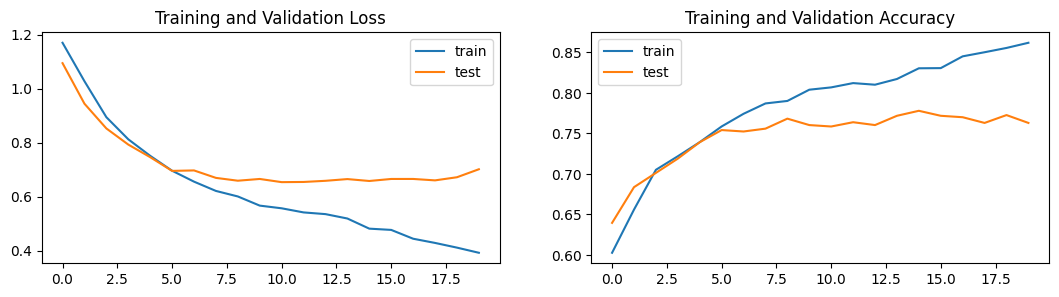

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


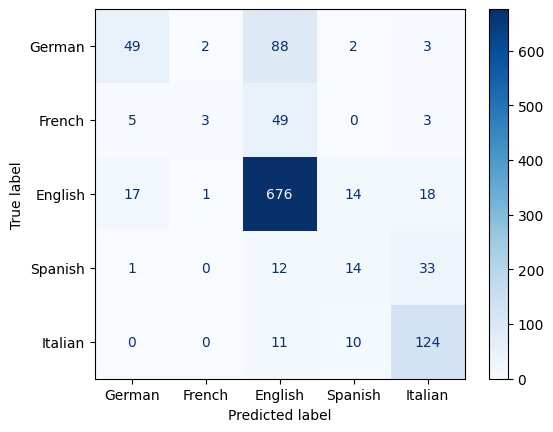

In [32]:
plot_history(history)
plot_confusion_matrix(model)

In [33]:
model = build_model_multi(n_hidden=64)
history = model.fit(X_train, Y_train, epochs=20, batch_size=128, validation_data=(X_test, Y_test), verbose=0)

Train accuracy: 0.941
Test  accuracy: 0.766


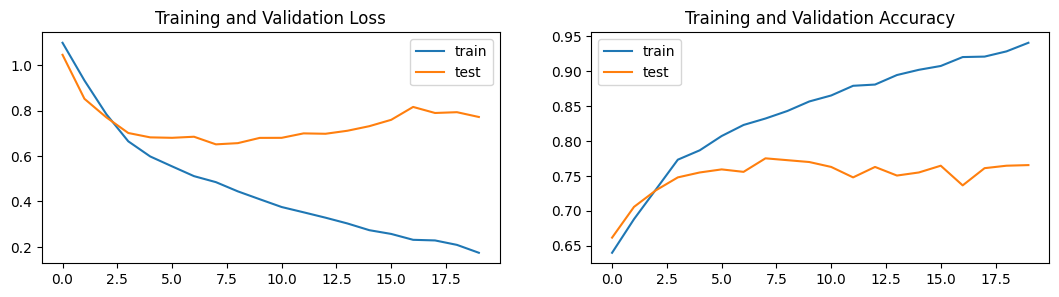

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


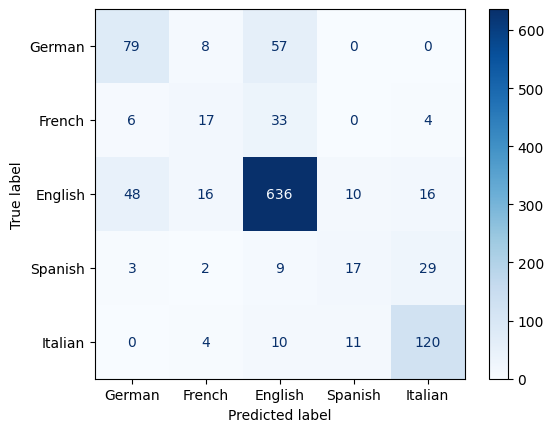

In [34]:
plot_history(history)
plot_confusion_matrix(model)

In [35]:
model = build_model_multi(n_hidden=85)
history = model.fit(X_train, Y_train, epochs=20, batch_size=128, validation_data=(X_test, Y_test), verbose=0)

Train accuracy: 0.945
Test  accuracy: 0.734


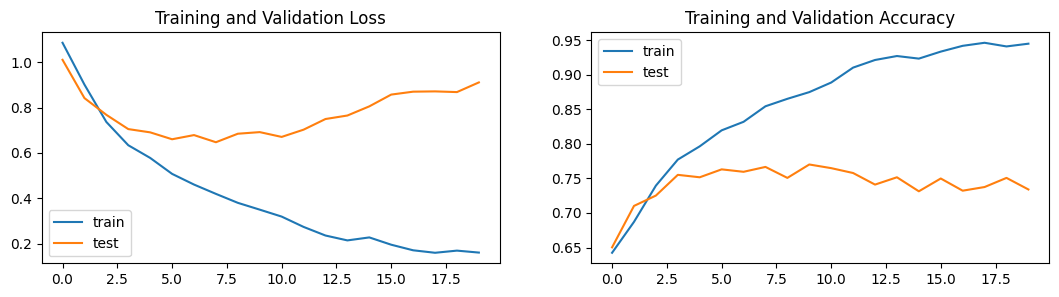

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


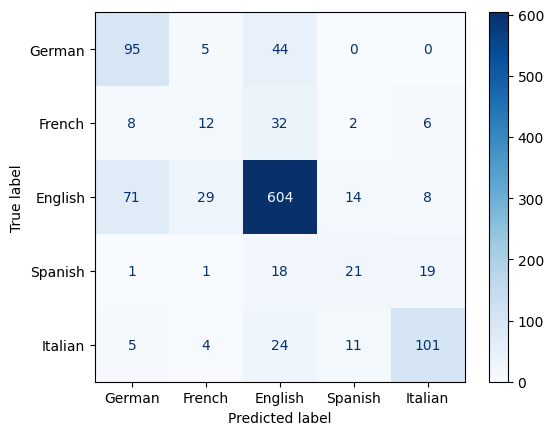

In [36]:
plot_history(history)
plot_confusion_matrix(model)

In [37]:
model = build_model_multi(n_hidden=100)
history = model.fit(X_train, Y_train, epochs=20, batch_size=128, validation_data=(X_test, Y_test), verbose=0)

Train accuracy: 0.956
Test  accuracy: 0.757


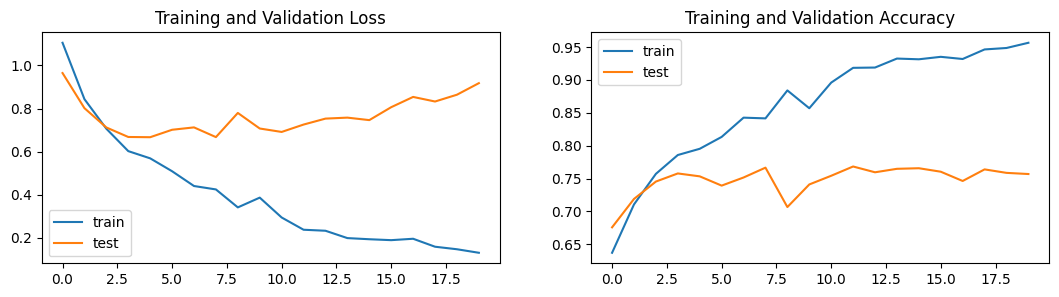

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


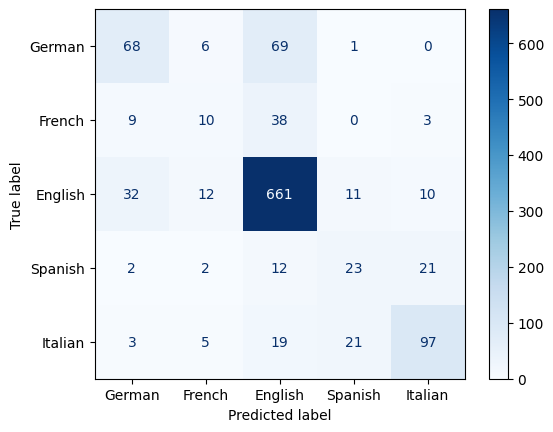

In [38]:
plot_history(history)
plot_confusion_matrix(model)

#### Findings

During the same 20 epochs the model is able to learn more and overfits on the training data. This was expected because the second model has a higher complexity and more capacity to learn. 
I cannot see a big difference in the performance of the model with different number of hidden units, batch size. The models are able to predict the language of the name with an accuracy of around 75% on the test set.
I was not able to significantly improve the performance of the stacked RNN model compared to the single RNN model.

### Class Imbalance Handling

Choose a method to address the class imbalance seen in the given example.
- minority resampling 
- class weights in the loss

Implement it and incorporate it in the training.
Evaluate the results and compare it with the results obtained with the unbalanced training.  

#### Class Weights in the Loss

In [39]:
from sklearn.utils import compute_class_weight

Y_test_list = [np.argmax(y) for y in Y_test]
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(Y_test_list), y=Y_test_list)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 1.5763888888888888, 1: 3.783333333333333, 2: 0.31267217630853994, 3: 3.783333333333333, 4: 1.5655172413793104}


In [40]:
model = build_model_multi(n_hidden=64)
history = model.fit(X_train, Y_train, epochs=20, batch_size=128, validation_data=(X_test, Y_test), verbose=0,
                    class_weight=class_weights)

Train accuracy: 0.865
Test  accuracy: 0.705


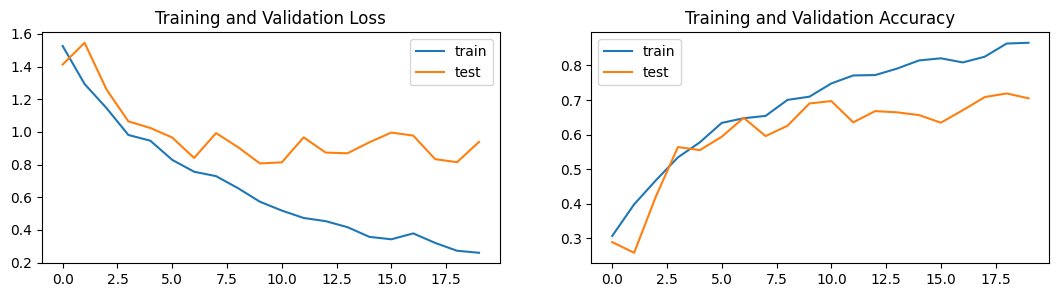

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


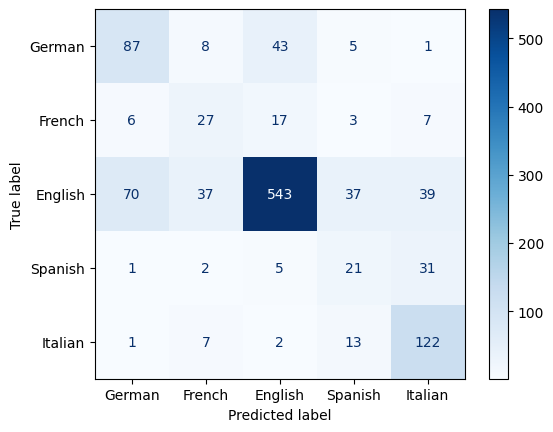

In [41]:
plot_history(history)
plot_confusion_matrix(model)

In [42]:
model = build_model_multi(n_hidden=128)
history = model.fit(X_train, Y_train, epochs=20, batch_size=128, validation_data=(X_test, Y_test), verbose=0,
                    class_weight=class_weights)

Train accuracy: 0.912
Test  accuracy: 0.722


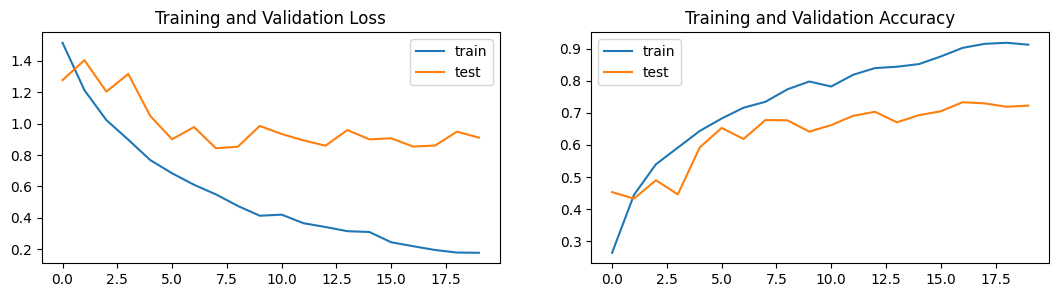

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


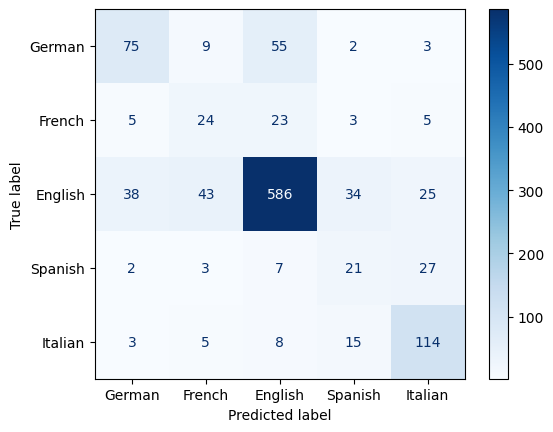

In [43]:
plot_history(history)
plot_confusion_matrix(model)

#### Importance of Class Imbalance Handling
If the classes are unbalanced, the model will be biased towards the majority class. This is the case in the given example. The model is biased towards the English language because it is the majority class. The model is not able to predict the minority classes as good as the majority class.
If a class is highly overrepresented it can happen, that a stupid classifier which always predicts this majority class will have a high accuracy.
